# Model recovery attack: `German-credit`

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_csv('../datasets/german-credit.csv', index_col=0).sample(frac=1)
min_values = df.drop(columns=["kredit"]).describe().transpose()['min'].to_numpy()
max_values = df.drop(columns=["kredit"]).describe().transpose()['max'].to_numpy()
x = df.drop(columns=["kredit"]).to_numpy()
x = (x-min_values)/(max_values-min_values)
y = df["kredit"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

num_classes = 2
train_size = len(x)

2022-02-10 15:25:41.269786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 15:26:05.436880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-02-10 15:26:05.661410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3168 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2022-02-10 15:26:05.662329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:

In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    output = tf.keras.layers.Dense(128, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(512, activation="relu")(xin)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

input_shape = train_ds.element_spec[0].shape
f = make_f(input_shape)
intermediate_shape = f.layers[-1].output_shape[1:]
g = make_g(intermediate_shape)

In [4]:
batch_size = 32
epoches = 5
# note that iterations is the number of batches we iterate
iterations = epoches * train_size // batch_size
# iterations = 100
learning_rate = 0.001

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_batches = train_ds.batch(batch_size=batch_size, drop_remainder=True).repeat(-1).take(iterations)
train_ref = []
z_ref = []

log = []
iter_count = 0
log_frequency = 100

for (x_batch, y_batch) in train_batches:
    
    with tf.GradientTape(persistent=True) as tape:
        z = f(x_batch, training=True)
        y_pred = g(z, training = True)
        if num_classes == 2:
            loss = tf.keras.losses.binary_crossentropy(y_true=y_batch, y_pred=y_pred)
            acc = tf.keras.metrics.binary_accuracy(y_batch, y_pred)
        else:
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y_batch, y_pred=y_pred)
            acc = tf.metrics.sparse_categorical_accuracy(y_batch, y_pred)
    var = f.trainable_variables + g.trainable_variables
    grad = tape.gradient(loss, var)
    optimizer.apply_gradients(zip(grad, var))

    iter_loss = sum(loss) / len(loss)
    iter_acc = sum(acc) / len(acc)
    log.append([iter_loss, iter_acc])
    iter_count += 1

    train_ref.append(x_batch)
    z_ref.append(z)

    if (iter_count - 1) % log_frequency == 0:
        print("Iteration %04d: Training loss: %0.4f training accuracy: %0.4f" % (iter_count, iter_loss, iter_acc))

2022-02-10 15:26:43.308042: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Iteration 0001: Training loss: 0.7177 training accuracy: 0.4688
Iteration 0101: Training loss: 0.5309 training accuracy: 0.7188


In [30]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(19, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

def make_random_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    # x = tf.keras.layers.Dense(1024, activation=act)(xin)
    # x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(19, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [38]:
f_temp = tf.keras.models.clone_model(f)
f_temp.set_weights(f.get_weights())

# generator = make_generator(intermediate_shape)
generator = make_random_generator((256,))

# inference_batches = attack_ds.batch(batch_size=32, drop_remainder=True).repeat(-1).take(attack_iterations)

attack_iter_count = 0
log = []

# for (x_batch, y_batch) in inference_batches:
for i in range(1):

    x_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    f_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

    z = z_ref[iterations - i - 1]
    x = train_ref[iterations - i - 1]

    # x_temp = tf.Variable(2 * np.random.rand(*(x.numpy().shape)) - 1)

    # x_temp = np.zeros_like(x.numpy())
    # x_temp.fill(0.5)
    # x_temp = tf.Variable(x_temp)

    for _ in range(200):

        for _ in range(50):
            with tf.GradientTape() as tape:
                # x_temp = generator(z, training=True)
                r = tf.random.normal(shape=z.shape, mean=0.5, stddev=0.25)
                # r = tf.constant(np.random.rand(*(z.numpy().shape)).astype("float32"))
                x_temp = generator(tf.concat([z, r], 1), training=True)
                loss_x = tf.keras.losses.MeanSquaredError()(f_temp(x_temp, training=False), z)
            vars = generator.trainable_variables
            grad = tape.gradient(loss_x, vars)
            x_opt.apply_gradients(zip(grad, vars))
            # loss = lambda: tf.keras.losses.MeanSquaredError()(f_temp(x_temp, training=False), z)
            # x_opt.minimize(loss, var_list=[x_temp])

        for _ in range(1):
            with tf.GradientTape() as tape:
                loss_f = tf.keras.losses.MeanSquaredError()(f_temp(x_temp, training=True), z)
            vars = f_temp.trainable_variables
            grad = tape.gradient(loss_f, vars)
            f_opt.apply_gradients(zip(grad, vars))

    attack_mse = tf.losses.MeanSquaredError()(x_temp, x)
    rg_uniform = tf.losses.MeanSquaredError()(x, np.random.rand(*(x.numpy().shape)))
    rg_normal = tf.losses.MeanSquaredError()(x, np.random.normal(0.5, 0.25, size=(x.numpy().shape)))
    log.append([rg_uniform, rg_normal, attack_mse])
    if (attack_iter_count % 10 == 0):
        print("Iteration %04d: RG: %0.4f reconstruction validation: %0.4f" % (attack_iter_count, rg_uniform, attack_mse))
    attack_iter_count += 1

Iteration 0000: RG: 0.2315 reconstruction validation: 0.0900


In [8]:
np.savetxt("./log/german.csv", np.array(log), delimiter=",")

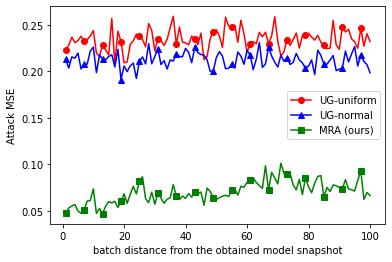

In [3]:
log = np.array(log)
plt.ylabel('Attack MSE')
plt.xlabel('batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(ran, log[:,0], 'ro-', ran, log[:,1], 'b^-', ran, log[:,2], 'gs-', markevery=6)
plt.legend(['UG-uniform', 'UG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/german.pdf")